In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from pycocotools.cocoeval import COCOeval
from fvcore.nn import FlopCountAnalysis, parameter_count_table
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [2]:
class CocoDataset(CocoDetection):
  def __getitem__(self, idx):
    img, anns = super().__getitem__(idx)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    boxes = []
    labels = []
    for ann in anns:
      bbox = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][0] + ann["bbox"][2], ann["bbox"][1] + ann["bbox"][3]] 
      boxes.append(bbox)
      labels.append(ann["category_id"])
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    target = {"boxes": boxes, "labels": labels}
    return img, target

In [3]:
train_dataset = CocoDataset(
  root    = "./SkyFusion.v1i.coco/train",
  annFile = "./SkyFusion.v1i.coco/train/_annotations.coco.json",
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

test_dataset = CocoDataset(
  root    = "./SkyFusion.v1i.coco/test",
  annFile = "./SkyFusion.v1i.coco/test/_annotations.coco.json",
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = CocoDataset(
  root    = "./SkyFusion.v1i.coco/valid",
  annFile = "./SkyFusion.v1i.coco/valid/_annotations.coco.json",
)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


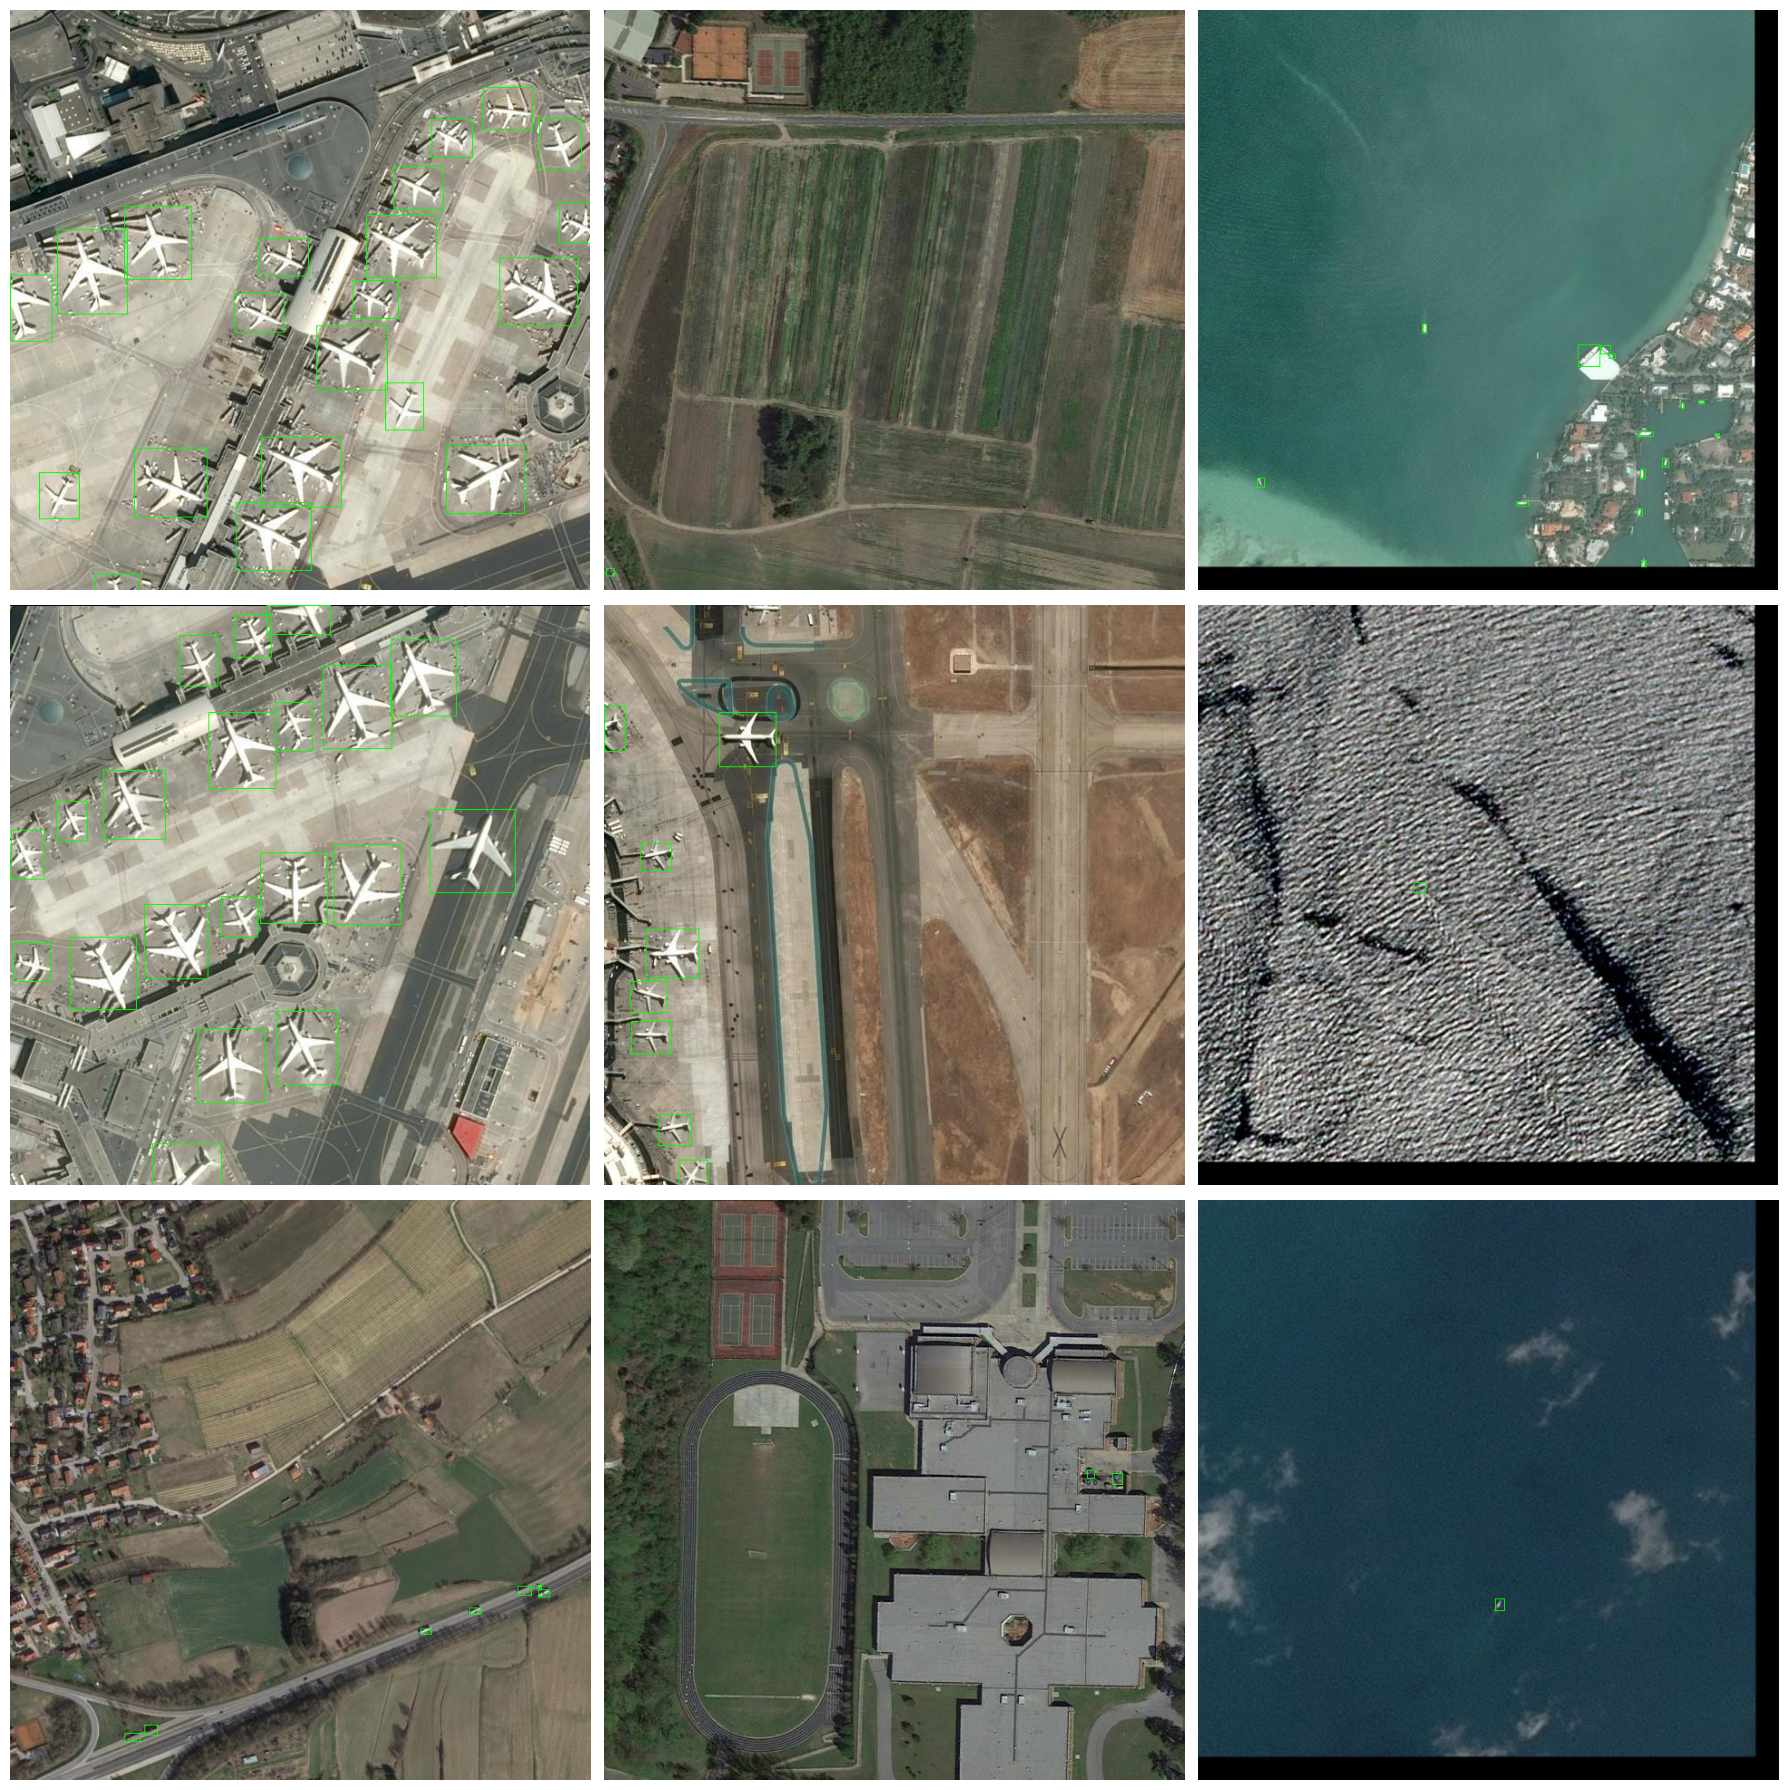

In [4]:
import cv2
import matplotlib.pyplot as plt

imgs, tgts = [], []
for batch_imgs, batch_tgts in train_loader:
  for img, tgt in zip(batch_imgs, batch_tgts):
    imgs.append(img)
    tgts.append(tgt)
    if len(imgs) == 9:
      break
  if len(imgs) == 9:
    break

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for ax, img_t, tgt in zip(axes.flatten(), imgs, tgts):
  img_np = (img_t.mul(255).permute(1, 2, 0).byte().cpu().numpy())
  img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

  for box in tgt["boxes"].cpu().numpy().astype(int):
    x1, y1, x2, y2 = box
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=1)

  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  ax.imshow(img_rgb)
  ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# # grab one batch
# images, targets = next(iter(train_loader))

# # images is a tuple/list of Tensors
# print("images  →", type(images),      "with", len(images), "elements")
# print("  └ image[0]:", images[0].shape, images[0].dtype)

# # targets is a tuple/list of dicts
# print("targets →", type(targets),     "with", len(targets), "elements")
# print("  └ target[0] keys:", targets[4].keys())
# print("     • boxes :", targets[4]['boxes'].shape, targets[4]['boxes'].dtype)
# print("     • labels:", targets[4]['labels'].shape, targets[4]['labels'].dtype)

In [6]:
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=num_classes).to(device)

cuda


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

x = torch.randn(1, 3, 600, 600).to(next(model.parameters()).device)

# Run analysis
model.eval()
flops = FlopCountAnalysis(model, x)

print(parameter_count_table(model))
print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

params = count_parameters(model)
print(f"Total trainable parameters: {params:,}")

model.train()

| name                                 | #elements or shape   |
|:-------------------------------------|:---------------------|
| model                                | 18.9M                |
|  backbone                            |  4.4M                |
|   backbone.body                      |   2.9M               |
|    backbone.body.0                   |    0.4K              |
|    backbone.body.1                   |    0.4K              |
|    backbone.body.2                   |    3.1K              |
|    backbone.body.3                   |    4.1K              |
|    backbone.body.4                   |    10.0K             |
|    backbone.body.5                   |    20.4K             |
|    backbone.body.6                   |    20.4K             |
|    backbone.body.7                   |    31.0K             |
|    backbone.body.8                   |    33.8K             |
|    backbone.body.9                   |    31.1K             |
|    backbone.body.10                  |

c:\Users\Eugene\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:4624: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(scale_factors[i], dtype=torch.float32)
c:\Users\Eugene\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\ops\boxes.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
c:\Users\Eugene\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\ops\boxes.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(

FLOPs: 18.42 GFLOPs
Total trainable parameters: 18,881,583


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
map_metric = MeanAveragePrecision(iou_type="bbox")  

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.005, weight_decay=0.0005)
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  
  for images, targets in train_loader:
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()

    train_loss += losses.item()
    
  train_loss /= len(train_loader)

  model.eval()
  map_metric.reset()
  with torch.no_grad():
    for images, targets in val_loader:
      images = [img.to(device) for img in images]
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      
      preds = model(images)
      map_metric.update(preds, targets)
      
    stats = map_metric.compute()
    print(stats)
    mAP50 = stats["map_50"].item()
    mAP50_95 = stats["map"].item()


  print(
    f"Epoch {epoch+1:02d} | "
    f"Train Loss: {train_loss:.4f} | "
    # f"Val Loss:   {val_loss:.4f} |"
    f"mAP50:   {mAP50:.4f} |"
    f"mAP50-95:   {mAP50_95:.4f} |"
  )

Epoch 01 | Train Loss: 675987809.1998 | mAP50:   0.0000 |mAP50-95:   0.0000 |
Epoch 02 | Train Loss: 12114.2342 | mAP50:   0.0000 |mAP50-95:   0.0000 |
Epoch 03 | Train Loss: 9299.3146 | mAP50:   0.0000 |mAP50-95:   0.0000 |
Epoch 04 | Train Loss: 169.5352 | mAP50:   0.0000 |mAP50-95:   0.0000 |
Epoch 05 | Train Loss: 146.2197 | mAP50:   0.0000 |mAP50-95:   0.0000 |
